# Deep Arithmetic Coding

## Setup

In [ ]:
!pip install cbor2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.4/285.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
%cd /content/

## Data Generation

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
# @title Prompt for Generating Synthetic Data
prompt = """
I am building a dataset for training a compression algorithm for IoT sensor networks (SSN/SOSA ontology). I need you to generate diverse natural language templates for sensor descriptions.

Please follow these strict rules:
1. Do NOT include specific numbers or IDs. Use placeholders: <ID>, <VALUE>, <UNIT>, <SENSOR_TYPE>, <LOCATION>.
2. Based on these seed examples, generate 50 distinct variations for each category using different vocabulary (synonyms like "device", "unit", "detector" instead of just "sensor").

Category A: Device Descriptions
Seed: "rangefinder #30 is a laser range finder sensor."
Target Output: "<SENSOR_TYPE> <ID> functions as a precision <SENSOR_TYPE> unit."

Category B: Observation Descriptions
Seed: "the height of tree #124"
Target Output: "measured <PROPERTY> of <OBJECT> <ID>"

Category C: Status Messages
Seed: "battery level is low"
Target Output: "Critical power failure on <SENSOR_TYPE> <ID>"

Generate 50 templates for each category (150 total lines). Output ONLY the raw text lines, no numbering or markdown.
"""

In [ ]:
# @title Gemini API Method
import google.generativeai as genai
import random
import os

def fetch_templates_from_gemini(TEMPLATE_FILE):
    if os.path.exists(TEMPLATE_FILE):
        print(f"Found existing {TEMPLATE_FILE}, skipping API call.")
        with open(TEMPLATE_FILE, "r") as f:
            return [line.strip() for line in f.readlines()]

    print("Calling Gemini API for synthetic templates...")
    genai.configure(api_key=GEMINI_API_KEY)
    model = genai.GenerativeModel('gemini-2.5-flash')

    response = model.generate_content(prompt)

    templates = [line.strip() for line in response.text.split('\n') if line.strip() and not line.startswith('*')]

    # Save
    with open(TEMPLATE_FILE, "w") as f:
        for t in templates:
            f.write(t + "\n")

    return templates

In [ ]:
import random
import os

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
def set_seeds(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_seeds(42)

In [ ]:
def gen_machine_strings():
    # Pure Python generators for high-entropy literals
    generators = [
        # lambda: f"{random.uniform(-50, 50):.2f}E{random.choice([1, 2, -1, -2])}", # Scientific
        # lambda: f"2025-{random.randint(1,12):02d}-{random.randint(1,28):02d}T{random.randint(0,23):02d}:00Z", # ISO8601
        # lambda: f"urn:dev:mac:{random.randint(10,99)}:{random.randint(10,99)}", # URN
        lambda: f"Error_0x{random.randint(0,255):02X}_Timeout", # Error Codes
        lambda: f"{random.choice(['http', 'https'])}://api.sensor-cloud.org/v1/dev/{random.randint(1000,9999)}" # URLs
    ]
    return random.choice(generators)()

def hydrate_template(template):
    # Vocabulary for placeholders
    vocab = {
        "<SENSOR_TYPE>": ["Lidar", "Thermistor", "Piezo", "Gyroscope", "Barometer"],
        "<OBJECT>": ["Lidar", "Thermistor", "Piezo", "Gyroscope", "Barometer"],
        "<PROPERTY>": ["displacement", "voltage", "amperage", "frequency", "pressure"],
        "<LOCATION>": ["Sector-7", "Edge-Node-B", "Roof-South", "Server-Rack-4"],
        "<UNIT>": ["mV", "mA", "kPa", "Hz", "degC"],
        "<VALUE>": ["HIGH", "LOW", "NORMAL", "CRITICAL"]
    }

    # Replace semantic tags
    for key, words in vocab.items():
        while key in template:
            template = template.replace(key, random.choice(words), 1)

    # Replace ID tag with RANDOM numbers (Prevent leakage)
    if "<ID>" in template:
        template = template.replace("<ID>", f"#{random.randint(100, 99999)}")

    return template

In [ ]:
def generate_dataset(num_lines, template_set):
    dataset = []
    for _ in range(num_lines):
        r = random.random()
        if r < 0.4:
            # 40% Machine Data (URLs/Errors) - Schema is constant
            dataset.append(gen_machine_strings())
        else:
            # 60% Natural Language - Using specific template set
            tmpl = random.choice(template_set)
            dataset.append(hydrate_template(tmpl))
    return dataset

In [ ]:
TEMPLATE_FILE = "./data/llm_raw_templates.txt"
TRAINING_DATASET = "./data/training_data_hybrid.txt"
VALIDATION_DATASET = "./data/validation_data_hybrid.txt"
TESTING_DATASET = "./data/testing_data_hybrid.txt"

In [ ]:
# templates = fetch_templates_from_gemini(TEMPLATE_FILE) # use this if not already generated from gemini

In [ ]:
if not os.path.exists(TEMPLATE_FILE):
    print(f"Error: {TEMPLATE_FILE} not found. Run the Gemini generation block first.")
else:
    with open(TEMPLATE_FILE, "r", encoding="utf-8") as f:
        all_templates = [line.strip() for line in f if line.strip()]

    # Shuffle templates to ensure random distribution before splitting
    random.shuffle(all_templates)

    # 80/20 Split on the TEMPLATES themselves
    train_split_index = int(len(all_templates) * 0.8)
    val_split_index = int(len(all_templates) * 0.9)

    train_templates = all_templates[:train_split_index]
    val_templates = all_templates[train_split_index:val_split_index]
    test_templates = all_templates[val_split_index:]

    print(f"Total Templates: {len(all_templates)}")
    print(f"Training Templates: {len(train_templates)}")
    print(f"Testing Templates: {len(test_templates)}")
    print(f"Validation Templates: {len(val_templates)}")


    print("Generating Training Data (50,000 lines)...")
    train_lines = generate_dataset(50000, train_templates)

    print("Generating Validation Data (2,000 lines)...")
    val_lines = generate_dataset(2000, val_templates)

    print("Generating Testing Data (2,000 lines)...")
    test_lines = generate_dataset(2000, test_templates)


    with open(TRAINING_DATASET, "w", encoding="utf-8") as f:
          f.write("\n".join(train_lines))

    with open(VALIDATION_DATASET, "w", encoding="utf-8") as f:
          f.write("\n".join(val_lines))

    with open(TESTING_DATASET, "w", encoding="utf-8") as f:
          f.write("\n".join(test_lines))

    print(f"Saved {TRAINING_DATASET}, {VALIDATION_DATASET} and {TESTING_DATASET}")

## Training

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pickle
import glob


--- Analyzing Training Dataset ---
Number of lines: 50000
Min length: 18 chars
Max length: 79 chars
Mean length: 40.75 chars
Median length: 40 chars
Std Dev length: 14.45 chars


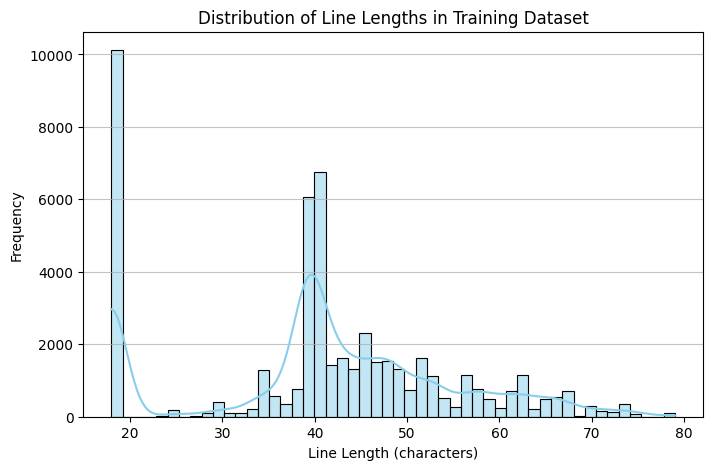


--- Analyzing Validation Dataset ---
Number of lines: 2000
Min length: 18 chars
Max length: 76 chars
Mean length: 37.79 chars
Median length: 39 chars
Std Dev length: 12.44 chars


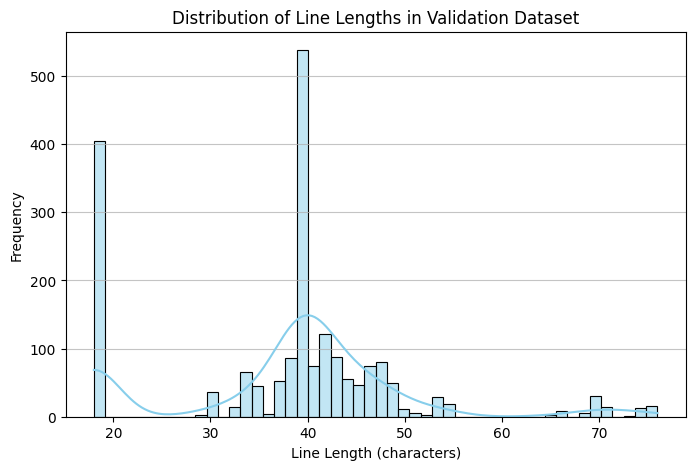


--- Analyzing Testing Dataset ---
Number of lines: 2000
Min length: 18 chars
Max length: 71 chars
Mean length: 43.78 chars
Median length: 45 chars
Std Dev length: 15.44 chars


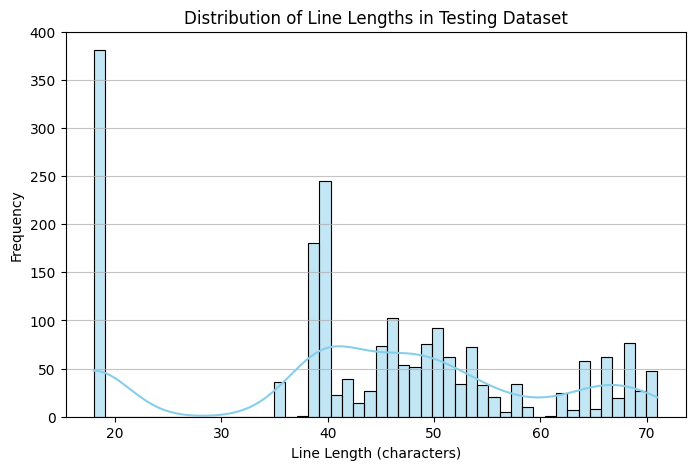

In [ ]:
# @title DA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_line_lengths(file_path, dataset_name):
    print(f"\n--- Analyzing {dataset_name} ---")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            line_lengths = [len(line.strip()) for line in f if line.strip()]

        if not line_lengths:
            print(f"No lines found in {file_path}.")
            return

        # Calculate summary statistics
        min_len = np.min(line_lengths)
        max_len = np.max(line_lengths)
        mean_len = np.mean(line_lengths)
        median_len = np.median(line_lengths)
        std_dev_len = np.std(line_lengths)

        print(f"Number of lines: {len(line_lengths)}")
        print(f"Min length: {min_len:.0f} chars")
        print(f"Max length: {max_len:.0f} chars")
        print(f"Mean length: {mean_len:.2f} chars")
        print(f"Median length: {median_len:.0f} chars")
        print(f"Std Dev length: {std_dev_len:.2f} chars")

        # Plotting the distribution
        plt.figure(figsize=(8, 5))
        sns.histplot(line_lengths, bins=50, kde=True, color='skyblue')
        plt.title(f'Distribution of Line Lengths in {dataset_name}')
        plt.xlabel('Line Length (characters)')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")


In [ ]:
analyze_line_lengths(TRAINING_DATASET, "Training Dataset")
analyze_line_lengths(VALIDATION_DATASET, "Validation Dataset")
analyze_line_lengths(TESTING_DATASET, "Testing Dataset")

In [ ]:
# DATA_FILE = "./data/training_data_hybrid.txt"
# DATA_FILE = TRAINING_DATASET
BATCH_SIZE = 64
EMBEDDING_DIM = 16
RNN_UNITS = 128
# EPOCHS = 10

In [ ]:
# @title Creating Bucketed tf Dataset (taking variable length lines separately)

import tensorflow as tf
import numpy as np
import pickle

def create_dataset(DATA_FILE, mode="train"):
    print(f"Creating {mode} dataset\n")
    print("Loading text from file...")
    try:
        with open(DATA_FILE, 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Could not find {DATA_FILE}")
        exit()

    # Vocabulary (Index 0 is Padding)
    base_vocab = r"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ "

    unique_chars = sorted(set(base_vocab) | set("".join(lines)) | {'\n'})

    char2idx = {u:i+1 for i, u in enumerate(unique_chars)}
    idx2char = np.array(['<PAD>'] + unique_chars)
    vocab_size = len(idx2char)

    print(char2idx)
    print("\n")
    print(idx2char)

    with open('vocab.pkl', 'wb') as f:
        pickle.dump({'char2idx': char2idx, 'idx2char': idx2char}, f)

    print(f"Loaded {len(lines)} lines. Vocab Size: {vocab_size}")

    # Generator to yields variable length raw sequences
    def line_generator():
        for line in lines:
            # Add \n for EOS
            text = line + '\n'
            encoded = [char2idx.get(c, 0) for c in text]

            # Yield Input (x) and Target (y)
            # x: "Error..."
            # y: "rror...\n"
            yield encoded[:-1], encoded[1:]

    # Create Dataset from Generator (Variable Length)
    dataset = tf.data.Dataset.from_generator(
        line_generator,
        output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )

    # Based on the above plot, the spikes are at ~20, ~40, and tail at ~80.
    # We set boundaries to capture these groups.
    # Buckets: [0-25], [26-45], [46-65], [66+]
    bucket_boundaries = [25, 45, 65]
    bucket_batch_sizes = [BATCH_SIZE] * (len(bucket_boundaries) + 1)

    dataset = dataset.bucket_by_sequence_length(
        element_length_func=lambda x, y: tf.shape(x)[0],
        bucket_boundaries=bucket_boundaries,
        bucket_batch_sizes=bucket_batch_sizes,
        pad_to_bucket_boundary=False     # Means "Pad to the longest in the batch", not the bucket boundary itself. Most efficient.
    )

    # Prefetch for speed
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print("Bucketed Dataset created")

    # Verify shapes
    for x, y in dataset.take(3):
        print(f"Batch Shape: {x.shape}")

    return dataset, vocab_size

In [ ]:
train_ds, vocab_size = create_dataset(TRAINING_DATASET, "train")
val_ds, _ = create_dataset(VALIDATION_DATASET, "val")
test_ds, _ = create_dataset(TESTING_DATASET, "test")

Creating train dataset

Loading text from file...
{'\n': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '<': 30, '=': 31, '>': 32, '?': 33, '@': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, '\\': 62, ']': 63, '^': 64, '_': 65, '`': 66, 'a': 67, 'b': 68, 'c': 69, 'd': 70, 'e': 71, 'f': 72, 'g': 73, 'h': 74, 'i': 75, 'j': 76, 'k': 77, 'l': 78, 'm': 79, 'n': 80, 'o': 81, 'p': 82, 'q': 83, 'r': 84, 's': 85, 't': 86, 'u': 87, 'v': 88, 'w': 89, 'x': 90, 'y': 91, 'z': 92, '{': 93, '|': 94, '}': 95, '~': 96}


['<PAD>' '\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.'
 '/' '0' '1' '2'

In [ ]:
# @title Model

def build_model(vocab_size, embedding_dim, rnn_units, batch_size, is_training=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(batch_shape=(batch_size, None)),
        tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=not is_training,
                            dropout=0.2,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU Detected: {physical_devices[0]}")
else:
    print("No GPU found")

GPU Detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# @title Training

EPOCHS = 20

# Build Training Model (Batch 64)
model = build_model(vocab_size, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE, is_training=True)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.keras")


callbacks = [
    # Save ONLY the best model (Lowest Validation Loss)
    tf.keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        verbose=1
    ),

    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True
    ),

    # Stop if it stops improving for 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print(f"Starting Training for {EPOCHS} epochs...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Starting Training for 20 epochs...
Epoch 1/20
    781/Unknown - 34s 34ms/step - loss: 3.7468 - accuracy: 0.0845
Epoch 1: val_loss improved from inf to 3.45723, saving model to best_model.keras
783/783 [==============================] - 37s 37ms/step - loss: 3.7464 - accuracy: 0.0845 - val_loss: 3.4572 - val_accuracy: 0.1110
Epoch 2/20
781/783 [============================>.] - ETA: 0s - loss: 3.1977 - accuracy: 0.1203
Epoch 2: val_loss improved from 3.45723 to 2.83336, saving model to best_model.keras
783/783 [==============================] - 26s 33ms/step - loss: 3.1977 - accuracy: 0.1203 - val_loss: 2.8334 - val_accuracy: 0.1864
Epoch 3/20
780/783 [============================>.] - ETA: 0s - loss: 2.6849 - accuracy: 0.1966
Epoch 3: val_loss improved from 2.83336 to 2.37769, saving model to best_model.keras
783/783 [==============================] - 27s 35ms/step - loss: 2.6852 - accuracy: 0.1965 - val_loss: 2.3777 - val_accuracy: 0.2867
Epoch 4/20
781/783 [==========================

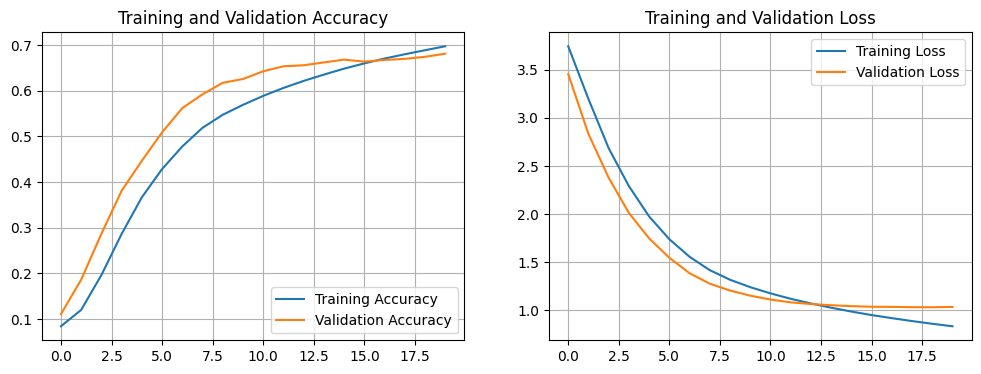

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

# Run the function
plot_history(history)

In [ ]:
# @title Loss and BPC on Test Set

print("\n--- Eval on Test Set ---")

# Evaluate
loss, accuracy = model.evaluate(test_ds, verbose=1)
bpc = loss / np.log(2)  # Formula: Loss / ln(2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Bits Per Character (BPC): {bpc:.4f}")


--- Eval on Test Set ---
32/32 [==============================] - 1s 24ms/step - loss: 1.0899 - accuracy: 0.6178
Test Loss: 1.0899
Test Accuracy: 61.78%
Bits Per Character (BPC): 1.5725


In [ ]:
# @title Export Model
#(Rebuild with Batch Size 1 for Compression usage)
print("Saving Model for Compression...")
compressor_model_path = "gru_compressor.keras"

# Rebuild model with batch_size=1
model_pred = build_model(vocab_size, EMBEDDING_DIM, RNN_UNITS, batch_size=1, is_training=False)

model_pred.load_weights("/content/drive/MyDrive/Projects/cbl/best_model.keras")

model_pred.build(tf.TensorShape([1, None]))

model_pred.save(compressor_model_path)
print(f"Done! Saved {compressor_model_path} and 'vocab.pkl'")

Saving Model for Compression...
Done! Saved gru_compressor.keras and 'vocab.pkl'


## CharRNN + AE

In [ ]:
import struct
import cbor2
import os

In [ ]:
# @title Arithmetic Encoder
class SimpleArithmeticCoder:
    def __init__(self, precision=32):
        self.MAX_VAL = (1 << precision) - 1
        self.QUARTER = 1 << (precision - 2)
        self.HALF = 1 << (precision - 1)
        self.THREE_QUARTER = self.QUARTER * 3

    def get_freqs_smoothed(self, probs):
        SCALE = 1 << 16
        freqs = (probs * SCALE).astype(np.int64)
        freqs += 1  # Label Smoothing
        cum_freqs = np.cumsum(freqs)
        cum_freqs = np.insert(cum_freqs, 0, 0)
        return cum_freqs.tolist(), int(cum_freqs[-1])

    def write_bit(self, bit, pending, f, buff, count):
        def out(b):
            nonlocal buff, count
            buff = (buff << 1) | b
            count += 1
            if count == 8:
                f.write(bytes([buff]))
                buff = 0
                count = 0
        out(bit)
        for _ in range(pending): out(1 - bit)
        return buff, count

In [ ]:
# @title Neural Compressor
class NeuralCompressor:
    def __init__(self, model_path, vocab_path, precision):
        self.model = tf.keras.models.load_model(model_path, compile=False)

        if not self.model.layers[1].stateful:
             print("WARNING: Loaded model is NOT stateful. Compression will be bad.")
        else:
             print("Model loaded. Memory enabled.")

        self.precision = precision
        with open(vocab_path, 'rb') as f:
            d = pickle.load(f)
            self.char2idx = d['char2idx']
            self.idx2char = d['idx2char']

        if '\n' in self.char2idx:
            self.eos_idx = self.char2idx['\n']
        else:
          raise "\n not in vocab"

        self.vocab_size = len(self.char2idx)
        self.coder = SimpleArithmeticCoder(precision=precision)

    def _predict_probs(self, idx):
        p = self.model(tf.expand_dims([idx], 0))
        return tf.nn.softmax(tf.squeeze(p, 0)).numpy()[0]

    def compress(self, text, out_path):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states'): layer.reset_states()

        text = text + '\n'
        indices = [self.char2idx.get(c, 0) for c in text]
        low, high = 0, self.coder.MAX_VAL
        pending, buff, count = 0, 0, 0
        prev = 0

        with open(out_path, 'wb') as f:
            # f.write(struct.pack('!I', len(text)))

            for i, idx in enumerate(indices):
                probs = np.ones(self.vocab_size)/self.vocab_size if i==0 else self._predict_probs(prev)
                cum, tot = self.coder.get_freqs_smoothed(probs)

                rng = high - low + 1
                new_high = low + (rng * int(cum[idx+1])) // tot - 1
                new_low  = low + (rng * int(cum[idx]))   // tot
                high, low = new_high, new_low

                while True:
                    if high < self.coder.HALF:
                        buff, count = self.coder.write_bit(0, pending, f, buff, count)
                        pending = 0
                        low, high = low << 1, (high << 1) | 1
                    elif low >= self.coder.HALF:
                        buff, count = self.coder.write_bit(1, pending, f, buff, count)
                        pending = 0
                        low, high = (low - self.coder.HALF) << 1, ((high - self.coder.HALF) << 1) | 1
                    elif low >= self.coder.QUARTER and high < self.coder.THREE_QUARTER:
                        pending += 1
                        low, high = (low - self.coder.QUARTER) << 1, ((high - self.coder.QUARTER) << 1) | 1
                    else: break
                prev = idx

            pending += 1
            bit = 0 if low < self.coder.QUARTER else 1
            buff, count = self.coder.write_bit(bit, pending, f, buff, count)
            if count > 0: f.write(bytes([buff << (8-count)]))

    def decompress(self, in_path):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states'): layer.reset_states()

        with open(in_path, 'rb') as f: b = f.read()

        # with open(in_path, 'rb') as f:
        #     header_bytes = f.read(4)
        #     length = struct.unpack('!I', header_bytes)[0]
        #     b = f.read()

        def bits():
            for byte in b:
                for i in range(7, -1, -1): yield (byte >> i) & 1
            while True: yield 0
        gen = bits()

        val = 0
        for _ in range(self.precision):
            val = (val << 1) | next(gen)

        low, high = 0, self.coder.MAX_VAL
        res, prev = [], 0

        # for i in range(length):
        i = 0
        while True:
            probs = np.ones(self.vocab_size)/self.vocab_size if i==0 else self._predict_probs(prev)

            i+=1
            cum, tot = self.coder.get_freqs_smoothed(probs)

            rng = high - low + 1
            s_val = ((val - low + 1) * tot - 1) // rng

            sym = 0
            for k in range(len(cum)-1):
                if cum[k+1] > s_val:
                    sym = k
                    break

            if sym == self.eos_idx:
                break

            new_high = low + (rng * int(cum[sym+1])) // tot - 1
            new_low  = low + (rng * int(cum[sym]))   // tot
            high, low = new_high, new_low

            while True:
                if high < self.coder.HALF: pass
                elif low >= self.coder.HALF:
                    val, low, high = val - self.coder.HALF, low - self.coder.HALF, high - self.coder.HALF
                elif low >= self.coder.QUARTER and high < self.coder.THREE_QUARTER:
                    val, low, high = val - self.coder.QUARTER, low - self.coder.QUARTER, high - self.coder.QUARTER
                else: break
                low, high = low << 1, (high << 1) | 1
                val = (val << 1) | next(gen)

            res.append(self.idx2char[sym])
            prev = sym

        return "".join(res)

## Testing and Comparison

In [ ]:
eng_en = NeuralCompressor("gru_compressor.keras", "vocab.pkl", 32)
eng_dec = NeuralCompressor("gru_compressor.keras", "vocab.pkl", 32)

In [ ]:
# @title Testing and Comparison (Single String)

TEST_STR = "the ground displacement speed at location of VCAB-DP1-BP-40"
print(f"\nOriginal: '{TEST_STR}'")


eng_en.compress(TEST_STR, "finalAC.bin")

print("Encoding Done")

dec = eng_dec.decompress("finalAC.bin")

print(f"Decoded:  '{dec}'")
print(f"Match:    {dec == TEST_STR}")

# Save CBOR data to a file and then get its size
with open("final_cbor.bin", "wb") as f:
    cbor2.dump(TEST_STR, f)

b_size = os.path.getsize("final_cbor.bin")

a_size = os.path.getsize("finalAC.bin")
print(f"Baseline (CBOR): {b_size} bytes")
print(f"AI Size:  {a_size} bytes")
print(f"Savings:  {(b_size - a_size)/b_size*100:.2f}%")


Original: 'the ground displacement speed at location of VCAB-DP1-BP-40'
Encoding Done
Decoded:  'the ground displacement speed at location of VCAB-DP1-BP-40'
Match:    True
Baseline (CBOR): 61 bytes
AI Size:  43 bytes
Savings:  29.51%


In [ ]:
# @title Compression Test
print("\n--- Running Real Compression on Samples ---")

with open(TESTING_DATASET, "r", encoding="utf-8") as f:
    test_lines = [line.strip() for line in f if line.strip()]


# Use all test_lines for evaluation (not just a sample of 10)
lines_to_evaluate = random.sample(test_lines, 100)

print(f"Loaded {len(lines_to_evaluate)} test lines from {TESTING_DATASET}")

results = []

print(f"{'Line Content':<40} | {'Orig':<5} | {'CBOR':<5} | {'AI':<5} | {'Savings':<9} | {'Match'}")
print("-" * 95)

total_cbor_matched = 0
total_ai_matched = 0
total_original_chars_matched = 0
successful_decodes = 0
individual_savings = [] # List to store savings for each matched line

cbor_temp_file = "temp.cbor"
ae_temp_file = "temp.ae"

for i, line in enumerate(lines_to_evaluate):
    # CBOR Baseline - dump to file and get size
    with open(cbor_temp_file, "wb") as f:
        cbor2.dump(line, f)
    cbor_len = os.path.getsize(cbor_temp_file)

    # AI Compression - dump to file and get size

    eng_en.compress(line, ae_temp_file)
    ai_len = os.path.getsize(ae_temp_file)

    # AI Decompression and Verification
    decompressed_line = eng_dec.decompress(ae_temp_file)
    match = (decompressed_line == line)

    # Calculate savings (for display for each line, regardless of match)
    savings = (cbor_len - ai_len) / cbor_len * 100 if cbor_len > 0 else 0.0

    # Accumulate statistics only for successfully decoded lines
    if match:
        total_cbor_matched += cbor_len
        total_ai_matched += ai_len
        total_original_chars_matched += len(line)
        successful_decodes += 1
        individual_savings.append(savings) # Store individual savings

    # Display results for each line
    disp_line = (line[:37] + '..') if len(line) > 37 else line
    print(f"{disp_line:<40} | {len(line):<5} | {cbor_len:<5} | {ai_len:<5} | {savings:>8.1f}% | {str(match):<5}")

print("-" * 95)

total_lines_processed = len(lines_to_evaluate)

# Calculate Decoding Accuracy
decoding_accuracy = (successful_decodes / total_lines_processed) * 100 if total_lines_processed > 0 else 0.0
print(f"Decoding Accuracy: {decoding_accuracy:.2f}% ({successful_decodes}/{total_lines_processed} lines matched)")

# Calculate overall statistics for matched lines only
if individual_savings:
    avg_savings_matched = np.mean(individual_savings)
    print(f"Average Savings per Matched Line: {avg_savings_matched:.2f}%")
else:
    print("No successful decodes to calculate average savings.")

if total_original_chars_matched > 0:
    # BPC = (Compressed Bits) / (Original Characters)
    bpc_empirical = (total_ai_matched * 8) / total_original_chars_matched
    print(f"Total BPC (Empirical, Matched Lines Only): {bpc_empirical:.2f} bits/char")
else:
    print("No successful decodes to calculate empirical BPC.")

# Clean up temporary files
if os.path.exists(cbor_temp_file): os.remove(cbor_temp_file)
if os.path.exists(ae_temp_file): os.remove(ae_temp_file)


--- Running Real Compression on Samples ---
Loaded 100 test lines from /content/drive/MyDrive/Projects/cbl/testing_data_hybrid.txt
Line Content                             | Orig  | CBOR  | AI    | Savings   | Match
-----------------------------------------------------------------------------------------------
#22846 is a high-fidelity Barometer m..  | 55    | 57    | 18    |     68.4% | True 
Acquired voltage data regarding Piezo..  | 45    | 47    | 16    |     66.0% | True 
Maintenance alert issued for Thermist..  | 47    | 49    | 14    |     71.4% | True 
Temperature alert from Piezo #99315.     | 36    | 38    | 12    |     68.4% | True 
Registered voltage index from Piezo #..  | 43    | 45    | 13    |     71.1% | True 
#82904 is a high-fidelity Gyroscope m..  | 55    | 57    | 18    |     68.4% | True 
Gyroscope #34202 serves as an accurat..  | 49    | 51    | 12    |     76.5% | True 
Error_0x11_Timeout                       | 18    | 19    | 2     |     89.5% | True 
Mainten

### Testing and Comparison(Multiple Strings)

In [ ]:
test_strings = [
    "sensor #123 temperature is 25.6 C",
    "device status: online, battery 85%",
    "http://example.com/data/sensor_log_001.json",
    "pressure sensor reading 1012.3 hPa at location North_Tower",
    "Lidar #4829 operating normally, 12V supply.",
    "Flow rate detected by Piezo #105: 3.7 m/s.",
    "Atmospheric pressure for Barometer #77.92 is low.",
    "Measured voltage by Gyroscope #22 is 1.5 mV.",
    "Thermistor #001 reports 20.1 degC, status OK.",
    "Warning: Device #55 battery at 10% capacity.",
    "Info: System check on main server complete.",
    "https://data.iot-network.org/sensor/status?id=998",
    "Data packet received from edge node A-3.",
    "Humidity sensor reading 65% for plant monitoring unit #4.",
    "Acoustic detector #789 picked up unusual sound patterns.",
    "Power consumption for array 1 is 150W.",
    "Update: Firmware upgraded successfully on controller #5.",
    "Connection lost with gateway B, attempting reconnect."
]

print(f"Defined {len(test_strings)} test strings.")

Defined 18 test strings.


In [ ]:
test_strings = [
    "https://api.sensor-cloud.org/v1/dev/12345" , # Unseen ID (Should still be small, maybe 3-4 bytes)
    "https://api.sensor-cloud.org/v1/dev/99999",
    "https://api.sensor-cloud.org/v1/dev/ABCDE", # If the model learned "Numbers go here", this will surprise it and cost more bits.
    "Critical_System_Failure_Run_Away"           # Total Surprise, A string it has never seen
]

In [ ]:
import os

# Output directories
CBOR_OUTPUT_DIR = "./test/cbor/"
AE_OUTPUT_DIR = "./test/AE/"

# Create directories if they don't exist
os.makedirs(CBOR_OUTPUT_DIR, exist_ok=True)
os.makedirs(AE_OUTPUT_DIR, exist_ok=True)

print(f"Created directories: {CBOR_OUTPUT_DIR} and {AE_OUTPUT_DIR}")

Created directories: ./test/cbor/ and ./test/AE/


In [ ]:
compression_results = []

print("Starting compression process...")
for i, text_string in enumerate(test_strings):
    # CBOR Compression
    cbor_file_path = os.path.join(CBOR_OUTPUT_DIR, f"string_{i:02d}.cbor")
    with open(cbor_file_path, "wb") as f:
        cbor2.dump(text_string, f)
    cbor_size = os.path.getsize(cbor_file_path)

    ae_file_path = os.path.join(AE_OUTPUT_DIR, f"string_{i:02d}.ae")
    eng_en.compress(text_string, ae_file_path)
    ae_size = os.path.getsize(ae_file_path)

    # AE Decompression and Verification
    decompressed_text = eng_dec.decompress(ae_file_path)
    match = (decompressed_text == text_string)

    compression_results.append({
        "original_string": text_string,
        "cbor_size": cbor_size,
        "ai_size": ae_size,
        "match": match
    })
    # print(f"Processed string {i+1}/{len(test_strings)}: '{text_string[:50]}...' (CBOR: {cbor_size} bytes, AI: {ae_size} bytes)")

print("Compression complete.")

Starting compression process...
Compression complete.


In [ ]:
print("\n--- Compression Results Summary ---")
print(f"{'String (first 50 chars)':<55} | {'CBOR Size (bytes)':<18} | {'AI Size (bytes)':<15} | {'Savings (%)':<12} | {'Match'}")
print("-" * 120)

for result in compression_results:
    original_string = result["original_string"]
    cbor_size = result["cbor_size"]
    ai_size = result["ai_size"]
    match = result["match"]

    # Calculate savings, handle cases where CBOR size is zero or AI is larger
    if cbor_size > 0:
        savings = (cbor_size - ai_size) / cbor_size * 100
    else:
        savings = 0.0 # Or some other indicator for non-compressible/zero-length strings

    print(f"{original_string[:50]:<55} | {cbor_size:<18} | {ai_size:<15} | {savings:>10.2f}% | {str(match):<5}")


--- Compression Results Summary ---
String (first 50 chars)                                 | CBOR Size (bytes)  | AI Size (bytes) | Savings (%)  | Match
------------------------------------------------------------------------------------------------------------------------
https://api.sensor-cloud.org/v1/dev/12345               | 43                 | 5               |      88.37% | True 
https://api.sensor-cloud.org/v1/dev/99999               | 43                 | 5               |      88.37% | True 
https://api.sensor-cloud.org/v1/dev/ABCDE               | 43                 | 12              |      72.09% | True 
Critical_System_Failure_Run_Away                        | 34                 | 29              |      14.71% | True 


## Other

In [ ]:

# @title PTQ
# import tensorflow as tf
# import numpy as np
# import os

# model = tf.keras.models.load_model("gru_compressor.keras", compile=False)

# # Create the Representative Dataset
# # The converter needs to see ~100 real samples to know the range of values inside the GRU (e.g., is it -1.0 to 1.0 or -5.0 to 5.0?)
# def representative_data_gen():
#     with open("vocab.pkl", 'rb') as f:
#         d = pickle.load(f)
#         char2idx = d['char2idx']
#         idx2char = d['idx2char']

#     for line in open("training_data_hybrid.txt", "r").readlines()[:200]:
#         text = line.strip() + '\n'
#         # Convert text to indices
#         indices = [char2idx.get(c, 0) for c in text]

#         # Since the exported model expects (1, 1), yield individual chars
#         for idx in indices:
#             # Shape must match model input: (1, 1)
#             yield [np.array([[idx]], dtype=np.float32)]


# # Configure the Converter
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

# # Enable optimizations
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Enforce full integer quantization (Input/Output are int8)
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

# # Convert and Save
# print("Converting to TFLite (Int8)... this may take a minute...")
# tflite_model_quant = converter.convert()

# with open("compressor_int8.tflite", "wb") as f:
#     f.write(tflite_model_quant)

# print(f"Saved 'compressor_int8.tflite' ({len(tflite_model_quant)//1024} KB)")

In [ ]:
# @title Simple Data Gen (Not Used)

# with open(TEMPLATE_FILE, "r", encoding="utf-8") as f:
#     templates = [line.strip() for line in f if line.strip()]

# print(f"Loaded {len(templates)} templates. First 100 chars of the first template: {templates[0][:100]}")

# dataset = []

# print(f"Generating 50,000 hybrid lines...")
# for _ in range(50000):
#     r = random.random()
#     if r < 0.4:
#         # 40% Pure Machine Data (Hardest to compress)
#         dataset.append(gen_machine_strings())
#     else:
#         # 60% Natural Language Templates
#         tmpl = random.choice(templates)
#         dataset.append(hydrate_template(tmpl))

# random.shuffle(dataset)

# with open(TRAINING_DATASET, "w", encoding="utf-8") as f:
#     for line in dataset:
#         f.write(line + "\n")

# print(f"Success! Saved to {TRAINING_DATASET}")

In [ ]:
# @title Creating tf Dataset (taking all lines as continuous text)

# print("Loading text from file...")
# try:
#     text = open(DATA_FILE, 'rb').read().decode(encoding='utf-8')
# except FileNotFoundError:
#     print(f"Error: Could not find {DATA_FILE}")
#     print("Please check the path.")
#     exit()

# base_vocab = r"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ "

# # Taking the Union (|) of the standard set and the file's set
# unique_chars = sorted(set(base_vocab) | set(text))
# vocab_size = len(unique_chars)

# print(f"Text Length: {len(text)} characters")
# print(f"Vocab Size:  {vocab_size} characters (Standard + File)")

# # Mappings
# char2idx = {u:i for i, u in enumerate(unique_chars)}
# idx2char = np.array(unique_chars)

# with open('vocab.pkl', 'wb') as f:
#     pickle.dump({'char2idx': char2idx, 'idx2char': idx2char}, f)
# print("Saved 'vocab.pkl'")

# # Vectorize text
# text_as_int = np.array([char2idx[c] for c in text])


# char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
# sequences = char_dataset.batch(SEQ_LENGTH+1, drop_remainder=True)

# def split_input_target(chunk):
#     input_text = chunk[:-1]
#     target_text = chunk[1:]
#     return input_text, target_text

# dataset = sequences.map(split_input_target)
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

Loading text from file...
Text Length: 2093613 characters
Vocab Size:  96 characters (Standard + File)
Saved 'vocab.pkl'
